## Modelling TRISO Particles in a Graphite Matrix

We have to create a Universe representing the single TRISO particle, composed by:
* Outer Pyrolitic Carbide (OPyC)
* Silicon-Carbide (SiC)
* Inner Pyrolitic Carbide (IPyC)
* Porous Carbon Buffer (C)
* UOC Kernel

After creating the TRISO particle universe, we have to define a space cube and an number of randomly generated sphere locations where we can place spheres of a certain defined outer radius such that a packing fraction is respected. This can be done using *openmc.model.pack_spheres*, which returns the coordinates of the generated centers associated to the spheres necessary to fill the given area. These centers must be used to position the TRISO universes within the lattice; fo each center we have to use *openmc.model.TRISO(outer_radius, TRISO_univ, center)* to create a TRISO particle object which is a Cell with the position given by the randomly assigned center.

The final step will be to create a Cell with a region equal to that used to generate random sphere locations, and filled with a lattice of TRISO particles, using *openmc.model.create_triso_lattice()*

In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

## Materials Definition

In [2]:
# Materials

# Fuel Kernel of UCO TRISO-coated fuel particle
# atom ratio: O-to-U=1.5, C-to-U=0.4
e = 0.15
kernel = openmc.Material(name='Fuel Kernel')
kernel.add_nuclide('U235', e*3.3e-1) # U235 enrichment 15% in weight
kernel.add_nuclide('U238', (3.3e-1)*(1.0-e))
kernel.add_nuclide('O16', 5e-1)
kernel.add_element('C', 1.3e-1)
kernel.set_density('g/cm3', 11.0)

# Porous Carbon Buffer
buffer = openmc.Material(name='Porous Buffer')
buffer.add_element('C', 1.0)
buffer.set_density('g/cm3', 1.0)
buffer.add_s_alpha_beta('c_Graphite') # element is very influent on scattering

# Inner Pyrolitic Carbide
IPyC = openmc.Material(name='Inner Pyrolitic Carbide')
IPyC.add_element('C', 1.0)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')

# Silicon Carbide
SiC = openmc.Material(name='Silicon Carbide')
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)
SiC.set_density('g/cm3', 3)

# Outer Pyrolitic Carbide
OPyC = openmc.Material(name='Outer Pyrolitic Carbide')
OPyC.add_element('C', 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite')

# Graphite of the Lattice Matrix in which we distribute the TRISO particles
graphite = openmc.Material()
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.2)
graphite.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([kernel, buffer, IPyC, SiC, OPyC, graphite])
materials.export_to_xml()

## Geometry - TRISO particle universe

In [3]:
# GEOMETRY for TRISO particles
r_kernel = 210e-4 #cm = 210micron
r_buffer = 310e-4 #cm
r_ipc = 350e-4    #cm
r_sic = 390e-4    #cm
r_opc = 430e-4    #cm

# Spherical regions
radii = [r_kernel, r_buffer, r_ipc, r_sic, r_opc]
spheres = [openmc.Sphere(r=radius) for radius in radii]

# Cells
kernel_cell = openmc.Cell(fill=kernel, region=-spheres[0])
buffer_cell = openmc.Cell(fill=buffer, region=+spheres[0] & -spheres[1])
IPyC_cell = openmc.Cell(fill=IPyC, region=+spheres[1] & -spheres[2])
SiC_cell = openmc.Cell(fill=SiC, region=+spheres[2] & -spheres[3])
OPyC_cell = openmc.Cell(fill=OPyC, region=+spheres[3] & -spheres[4])

TRISO_cells = [kernel_cell, buffer_cell, IPyC_cell, SiC_cell, OPyC_cell]

# Defining the Universe TRISO particle!!!
TRISO_universe = openmc.Universe(cells=TRISO_cells)

## Geometry - Packing Spheres

In [4]:
# Box region
min_x = openmc.XPlane(x0=-0.5, boundary_type='reflective')
max_x = openmc.XPlane(x0=0.5, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.5, boundary_type='reflective')
max_y = openmc.YPlane(y0=0.5, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.5, boundary_type='reflective')
max_z = openmc.ZPlane(z0=0.5, boundary_type='reflective')
cylinder = openmc.ZCylinder(r=0.5, boundary_type='reflective')

# Lattice 1 is a cube that defines where we will put our TRISOs
lattice_region = (-max_x & -max_y & -max_z) & (+min_x & +min_y & +min_z)
# Lattice 2 has a cylindrical shape!!! Which is actually equal to that of a pellet!!!
lattice_region2 = -cylinder & -max_z & +min_z

# radius of each sphere = OPyC radius
outer_radius = radii[-1]

# Operation of centers generation using pack_spheres
# packing_fraction (pf)=30%, seed=124848351
centers = openmc.model.pack_spheres(radius=outer_radius, region=lattice_region2, pf=0.3, seed=124848351)

In [5]:
# Generation of TRISO particles and positioning where centers are defined
TRISOs = [openmc.model.TRISO(outer_radius=outer_radius,
                             fill=TRISO_universe,
                             center=center_xyz) for center_xyz in centers]
# We have generated a TRISO particle object made of a TRISO particle universe (layers) and a coordinate position

## Geometry - Lattice Definition

In [6]:
# Box Cell Definition
box = openmc.Cell(region = lattice_region2)

trisos = TRISOs
lower_left = [-0.5, -0.5, -0.5]
pitch = [1/3, 1/3, 1/3]
shape = (3, 3, 3)

# Lattice definition which can be used as a openmc.Matrial within the Box Cell
lattice = openmc.model.create_triso_lattice(trisos=trisos,
                                            lower_left=lower_left,
                                            pitch=pitch,
                                            shape=shape,
                                            background=graphite)
# Filling the Box Cell
box.fill = lattice
# Universe for the Lattice of TRISO particles
lattice_universe = openmc.Universe(cells=[box])

In [7]:
# EXPORT Geometry
geometry = openmc.Geometry(lattice_universe)
geometry.export_to_xml()

## Plotting the Lattice of TRISO particles

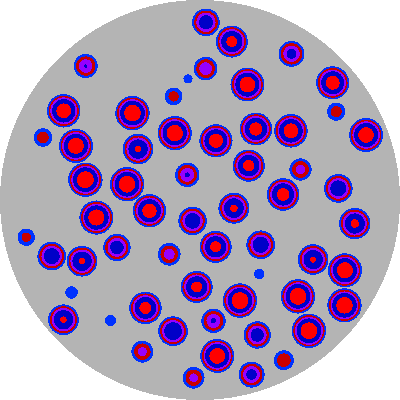

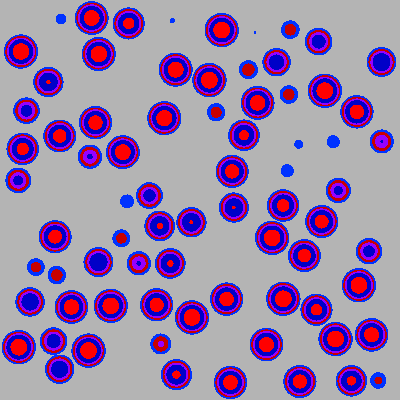

In [8]:
# Plotting XY - Cylindrical Lattice like Pellets
plot1 = openmc.Plot.from_geometry(geometry)
plot1.basis = 'xy'
plot1.center = (0,0,0)
plot1.width = (1,1)
plot1.color_by = 'material'
plot1.colors = {kernel:(255,0,0), buffer:(0,0,200), IPyC:(150,0,255), SiC:(200,0,0), OPyC:(0,50,255), graphite:(180,180,180)}

# Plotting XZ
plot2 = openmc.Plot.from_geometry(geometry)
plot2.basis = 'xz'
plot2.center = (0,0,0)
plot2.width = (1,1)
plot2.color_by = 'material'
plot2.colors = {kernel:(255,0,0), buffer:(0,0,200), IPyC:(150,0,255), SiC:(200,0,0), OPyC:(0,50,255), graphite:(180,180,180)}

plots = openmc.Plots([plot1, plot2])
openmc.plot_inline(plots)